In [1]:
from pysad.models import xStream
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from pysad.utils import Data
from river.drift import ADWIN, DDM, EDDM, PageHinkley, HDDM_A, HDDM_W, KSWIN
from sklearn.model_selection import train_test_split

from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 2. Dataset

In [2]:
base_path = '#datasets'
dataset_scaled = pd.read_csv(f'{base_path}/Tennessee_Event-Driven/datasets/dataset_standard_scaled.csv',index_col=False)


# 3. Stream Machine Learning

In [3]:
samples = dataset_scaled[dataset_scaled.columns[:-1]]
labels = dataset_scaled[dataset_scaled.columns[-1]].to_frame()

# 4. Concept Drift Detection
I stole this picture from :

    "Gama, J., Žliobaitė, I., Bifet, A., Pechenizkiy, M., & Bouchachia, A. (2014). A survey on concept drift adaptation. ACM computing surveys (CSUR), 46(4), 1-37."

I think it nicely shows categoies of concept drifts.
![missing_image](images/Pattern_of_change_over_time_(outlier_is_not_concept_drift).png "Pattern of change over time (outlier is not concept drift)")

In [4]:
# check where the fault_id changes - i.e. the concept_drift should occur and mark that sample with "1" (initial sample has NA - fill with 0)
dataset_scaled['fault_id_change'] = dataset_scaled['fault_id'].diff().fillna(0)

In [5]:
dataset_scaled[dataset_scaled['fault_id_change'] != 0].head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,fault_id,fault_id_change
1460,-0.135542,-0.524896,-0.492994,-0.054211,-0.987287,-1.285137,-0.168249,0.878383,-0.164558,-0.150351,...,-0.276954,0.037310,0.036727,-0.136297,2.061118,-0.065809,-0.150985,-0.452600,1,1.0
2900,-0.030999,-0.343700,-0.419469,0.073448,0.924679,-1.495925,-0.157704,0.953235,-0.164558,-0.069701,...,-0.431869,0.173012,0.076962,-0.154326,-2.714047,-0.134900,-0.156721,-0.289216,2,1.0
4340,0.004211,-0.621376,-0.233271,-0.353160,1.616335,0.794846,-0.243386,-0.039332,0.274466,-0.144001,...,-0.434017,0.052163,0.082485,-1.713662,-1.349287,-0.126842,-0.071859,-0.281409,3,1.0
5780,-0.085480,0.618753,0.693899,-0.421029,1.241872,-0.138201,-0.246023,0.366895,2.762265,-0.090784,...,-0.164783,0.075118,0.024657,-0.346862,-0.140671,-0.152638,0.419007,-0.186864,4,1.0
7220,0.176494,-0.190743,0.045548,-0.043977,1.003977,-0.404786,-0.185386,0.894757,0.128125,-0.039473,...,-0.522443,0.133517,0.077278,2.605128,-0.257992,-0.023297,-0.039635,-0.452504,5,1.0


In [6]:
# magnitude of row vectors - concept drift detectors take as input single value not list/vector
dataset_scaled['magnitude'] = dataset_scaled[dataset_scaled.columns[:-1]].apply(np.linalg.norm, axis=1)
data_stream = dataset_scaled['magnitude'].values

In [7]:
drift_detects = [ADWIN(), EDDM(), HDDM_A(), HDDM_W(), KSWIN(), PageHinkley()]


drift_count = {str(key):0 for key in drift_detects}
# Adding stream elements to ADWIN and verifying if drift occurred
for i, val in enumerate(data_stream):
    for j, drift_detect in enumerate(drift_detects):
        in_drift, in_warning = drift_detect.update(val)
        if in_drift:
            drift_count[str(drift_detect)] += 1
#         print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
print(f'Detected drifts: {drift_count}')

Detected drifts: {'ADWIN': 251, 'EDDM': 0, 'HDDM_A': 137, 'HDDM_W': 142, 'KSWIN': 292, 'PageHinkley': 50}


# 5. Anomaly Detection
Using River first


In [8]:
model = compose.Pipeline(
     preprocessing.MinMaxScaler(),
     anomaly.HalfSpaceTrees(seed=42)
 )

river_hst_count = 0
river_hst_score = []

for i, val in dataset_scaled.iterrows():
    features = val.to_dict()
    model = model.learn_one(features)
    # print(f'Anomaly score for x={val:.3f}: {hst.score_one(features):.3f}')
    score = model.score_one(features)
    river_hst_score.append(score)
    if score >= 0.95:
        river_hst_count += 1
print(f'Anamolies detected: {river_hst_count}')

Anamolies detected: 647


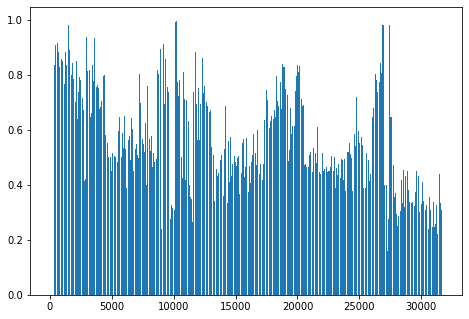

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(river_hst_score)+1),river_hst_score)
plt.show()

## PySad

In [ ]:
np.random.seed(61)  # Fix seed.

model = xStream()  # Init model.
calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=300)  # Init probability calibrator.
streaming_data = Data("data").get_iterator("arrhythmia.mat")  # Get streamer.

xstream_count = 0
xstream_score = []
print(len(data_stream))
for i, x in enumerate(data_stream): # Stream data.
    anomaly_score = model.fit_score_partial(x)  # Fit to an instance x and score it.

    calibrated_score = calibrator.fit_transform(anomaly_score)  # Fit & calibrate score.

    xstream_score.append(calibrated_score)
    # Output if the instance is anomalous.
    if calibrated_score > 0.95:  # If probability of being normal is less than 5%.
        xstream_count += 1
        print(f"Alert: {i}th data point is anomalous.")
print(f'Anamolies detected: {xstream_count}')

31700
Alert: 20th data point is anomalous.
Alert: 22th data point is anomalous.
Alert: 23th data point is anomalous.
Alert: 41th data point is anomalous.
Alert: 50th data point is anomalous.
Alert: 51th data point is anomalous.
Alert: 130th data point is anomalous.
Alert: 140th data point is anomalous.
Alert: 200th data point is anomalous.
Alert: 201th data point is anomalous.
Alert: 218th data point is anomalous.
Alert: 296th data point is anomalous.
Alert: 338th data point is anomalous.
Alert: 346th data point is anomalous.
Alert: 361th data point is anomalous.
Alert: 362th data point is anomalous.
Alert: 395th data point is anomalous.
Alert: 476th data point is anomalous.
Alert: 481th data point is anomalous.
Alert: 482th data point is anomalous.
Alert: 487th data point is anomalous.
Alert: 491th data point is anomalous.
Alert: 494th data point is anomalous.
Alert: 515th data point is anomalous.
Alert: 640th data point is anomalous.
Alert: 641th data point is anomalous.
Alert: 701th

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(xstream_score)+1),xstream_score)
plt.show()